In [2]:
import polars as pl
import numpy as np

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score

import lightgbm as lgb

import seaborn as sns

In [3]:
pl.__version__

'0.18.7'

In [4]:
lgb.__version__

'4.1.0'

In [5]:
df = pl.read_csv("../../input/titanic.csv")

In [6]:
USE_COL = ["pclass", "sex", "age", "sibsp", "parch", "fare", "embarked"]
CATEGORICAL_FEATURE = ["sex", "embarked"]
TARGET_COL = "survived"
FOLD_NUM = 5
SEED = 42

In [7]:
# 学習データとテストデータに分割する
train, test = train_test_split(
    df,
    test_size=0.3,
    random_state=SEED,
    shuffle=True,
    stratify=df.get_column(TARGET_COL),
)

In [8]:
# Categorical型への変換
for cat_col in CATEGORICAL_FEATURE:
    train = train.with_columns(pl.col(cat_col).cast(pl.Categorical))

    test = test.with_columns(pl.col(cat_col).cast(pl.Categorical))

In [9]:
# Foldの作成
fold_arr = np.zeros(train.height)
fold = KFold(n_splits=FOLD_NUM, shuffle=True, random_state=SEED)

for idx, (_, val_idx) in enumerate(fold.split(train)):
    fold_arr[val_idx] = idx

train = train.with_columns(pl.Series(fold_arr).cast(pl.Int64).alias("fold"))

In [10]:
# LightGBMで用いるパラメータを指定
params = {
    "objective": "binary",
    "max_depth": -1,
    "min_data_in_leaf": 10,  # 1つの葉に入る最小のデータ数
    "num_leaves": 24,  # 2**max_depthより少し小さめにすると過学習を防げる
    "learning_rate": 0.01,  # 1回のiterationで学習を進める割合、大きいと学習が早く終わる。小さいと学習は長いが高精度になりやすい。
    "bagging_freq": 5,  # 指定した回数ごとにbaggingを行う
    "feature_fraction": 0.9,  # 1回のiterationで利用する特徴量(列方向)の割合
    "bagging_fraction": 0.8,  # 1回のiterationで利用するデータ(行方向)の割合
    "verbose": -1,  # 出力するログレベルの変更、-1はFatalなログのみを出力
    "seed": SEED,  # ランダムシードの固定
    "lambda_l1": 0.4,  # 正則化のためのパラメータ
    "lambda_l2": 0.4,  # 正則化のためのパラメータ
}

In [11]:
# テストデータに対する推論、特徴量重要度(後述)を計算するために、モデルを保存するobjectを作成
models = []

# Cross Validationによる学習の実施
for fold in range(FOLD_NUM):
    print(f"Start fold {fold}")

    # foldごとにtrainとvalidに分ける
    train_fold = train.filter(pl.col("fold") != fold)
    valid_fold = train.filter(pl.col("fold") == fold)

    # X(説明変数)とy(目的変数)に分ける
    X_train = train_fold.select(USE_COL)
    X_valid = valid_fold.select(USE_COL)
    y_train = train_fold.select(TARGET_COL)
    y_valid = valid_fold.select(TARGET_COL)

    # LightGBMが認識可能な形にデータセットを変換
    lgb_train = lgb.Dataset(X_train.to_pandas(), y_train.to_pandas())
    lgb_eval = lgb.Dataset(
        X_valid.to_pandas(), y_valid.to_pandas(), reference=lgb_train
    )

    # モデルの学習
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=10000,  # 学習のiteration回数
        valid_sets=[lgb_train, lgb_eval],
        callbacks=[
            lgb.early_stopping(
                stopping_rounds=100
            ),  # Early stopingの回数、binary_loglossが改善しないiterationが100回続いたら学習を止める
            lgb.log_evaluation(100),  # 指定したiteration回数ごとにlogを出力する
        ],
    )

    # モデルを保存
    models.append([fold, model])

Start fold 0
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.450605	valid_1's binary_logloss: 0.513871
[200]	training's binary_logloss: 0.374398	valid_1's binary_logloss: 0.491611
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.379859	valid_1's binary_logloss: 0.491072
Start fold 1
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.456758	valid_1's binary_logloss: 0.521802
[200]	training's binary_logloss: 0.38052	valid_1's binary_logloss: 0.495941
[300]	training's binary_logloss: 0.338537	valid_1's binary_logloss: 0.495381
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.352237	valid_1's binary_logloss: 0.493658
Start fold 2
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.457166	valid_1's binary_logloss: 0.521148
[200]	training's binary_logloss: 0.377574	valid_1's binary_logloss: 0.494988
[300]	trainin

In [12]:
# 学習データ全体に対する推論結果を保存するobjectを作成
oof = np.zeros((len(train)))

# foldの値と学習済みモデルを利用し、モデルの評価を行う
for fold, model in models:
    valid_fold = train.filter(pl.col("fold") == fold)

    X_valid = valid_fold.select(USE_COL)
    y_valid = valid_fold.select(TARGET_COL)

    # validデータに対する推論
    y_valid_pred = model.predict(
        X_valid.to_pandas(), num_iteration=model.best_iteration
    )

    y_valid_pred = (y_valid_pred > 0.5).astype(int)

    score = roc_auc_score(y_valid, y_valid_pred)
    print(f"fold {fold} Score: {score}")

    is_valid = train.get_column("fold") == fold
    oof[is_valid] = y_valid_pred

fold 0 Score: 0.740847046817196
fold 1 Score: 0.7396252515090543
fold 2 Score: 0.7668553782810087
fold 3 Score: 0.7931681681681682
fold 4 Score: 0.7970734744707347


In [28]:
model

In [13]:
oof_score = roc_auc_score(train.get_column("survived"), oof)
oof_score

0.7680868248359415

<Axes: >

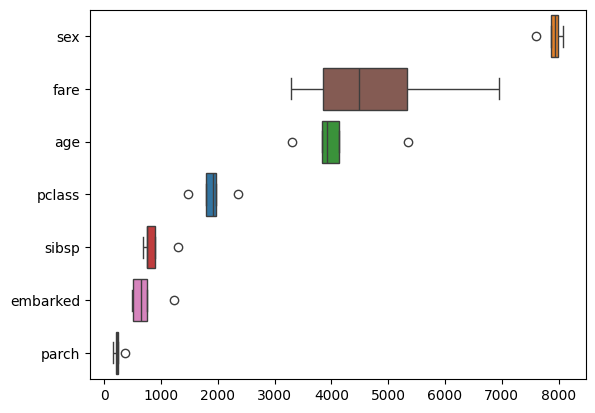

In [26]:
import pandas as pd

feature_importances = [
    model.feature_importance(importance_type="gain") for _, model in models
]
feature_importances_df = pd.DataFrame(feature_importances, columns=USE_COL)

order = feature_importances_df.mean().sort_values(ascending=False).index.tolist()

sns.boxplot(data=feature_importances_df, orient="h", order=order)

In [20]:
pred = np.array([model.predict(test[USE_COL].to_pandas()) for _, model in models])
pred = np.mean(pred, axis=0)
pred = (pred > 0.5).astype(int)